In [1]:
# import packages
import numpy as np
np.set_printoptions(precision=7)
np.set_printoptions(suppress=True)
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from umap import UMAP

In [2]:
# load the customer data from a CSV file

file_path = 'data.csv'
df = pd.read_csv(file_path)

In [3]:
# separate the customer IDs and the features to work only with
# with numeric metrics

customer_id = df[['CUST_ID']].copy()
df = df[df.columns[~df.columns.isin(['CUST_ID'])]]

In [4]:
# look for NaN values in the original dataset

df.isna().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

The features **MINIMUM_PAYMENTS** and **CREDIT_LIMIT** have some NaN values in the
dataset. Thus, we impute the median of each feature into those NaN values. The
median imputation does not change the mean significantly, while the median keeps
the same value.

In [5]:
# data imputation using the median into the NaN values

df.fillna(df.median(), inplace=True)
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,312.343947,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


# A. Data exploration: Histograms

In [6]:
def plot_hist_feature(data, title, number=None, nbins=50):
    """
    Plots the histogram for a given data and feature.
    data: array for the feature
    title: title for the figure
    number: # of figure, and it is used in the title
    nbins: grid of the histogram
    """
    plt.figure(figsize=(7, 4))
    plt.hist(data, nbins)
    plt.xlabel('Value', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(f"Histogram {number} - {title}", fontsize=17)
    plt.show()

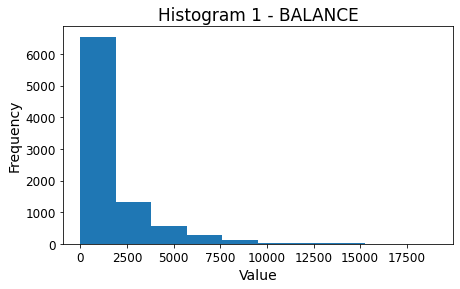

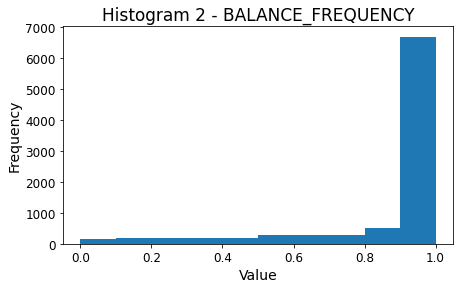

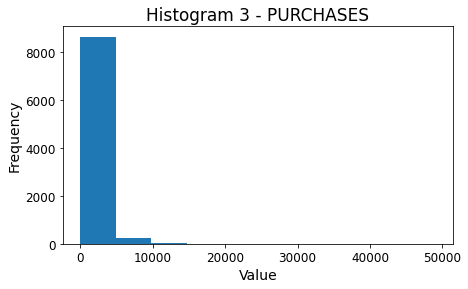

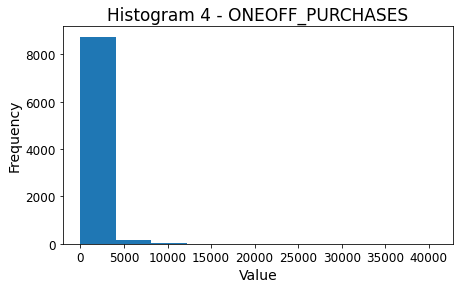

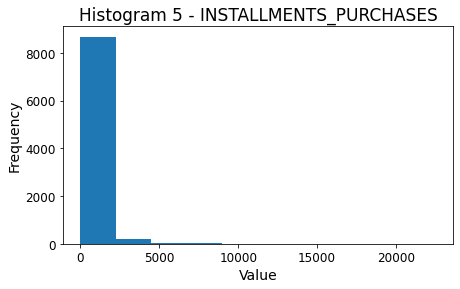

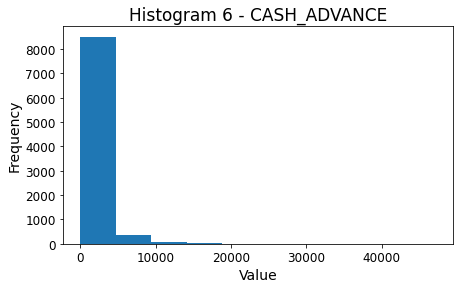

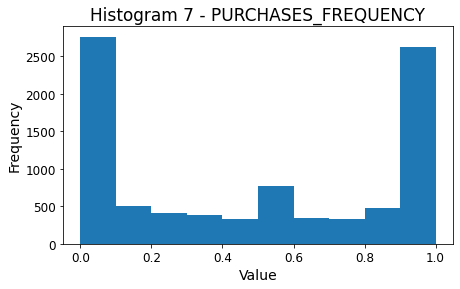

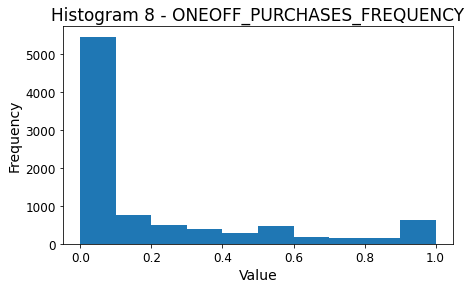

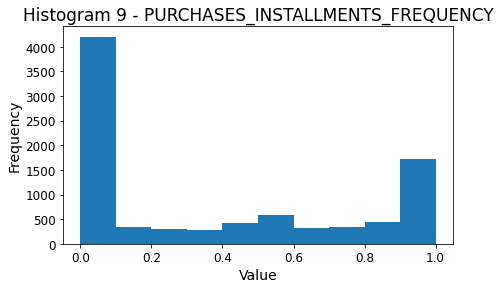

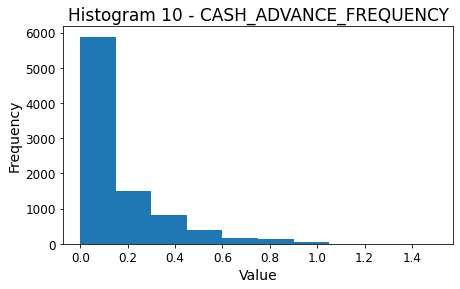

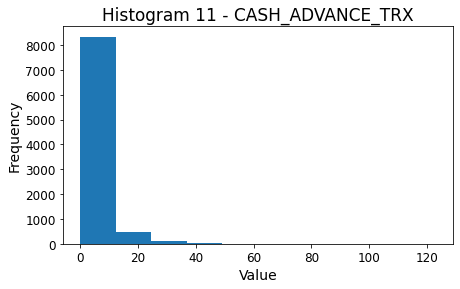

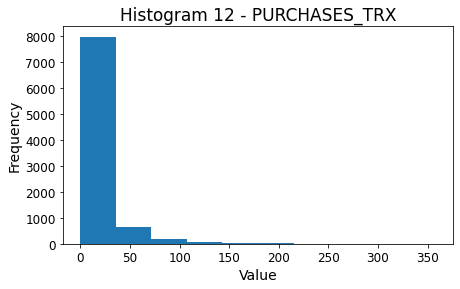

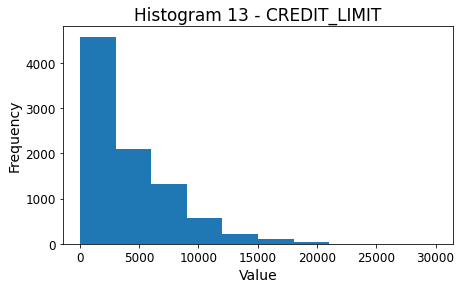

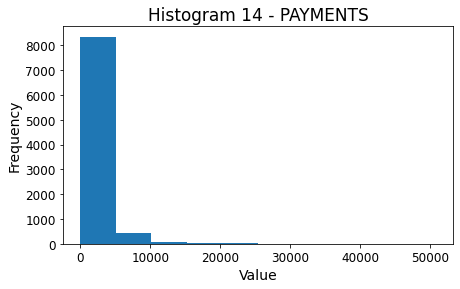

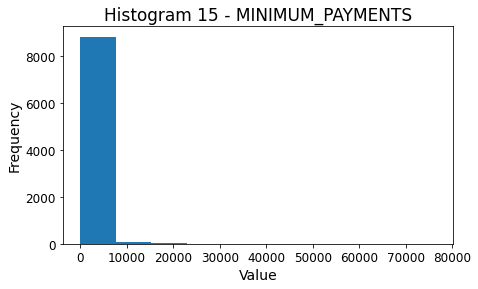

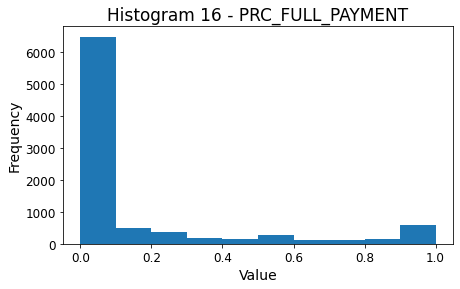

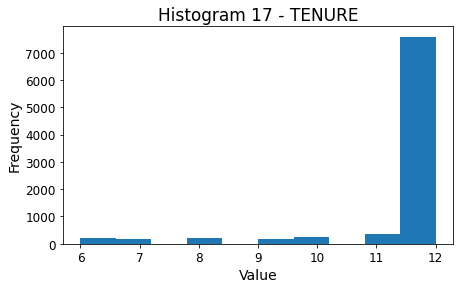

In [7]:
# plot the histogram for the features in the dataset

for i, feature in enumerate(df.columns):
    plot_hist_feature(df[feature], feature, i+1, nbins=None)

Data is highly skew, so the median imputation makes sense and preserves the mean well

In [8]:
# we save the skew metric of features for further analysis later in this
# notebook

skewness = df.skew()

# B. Data exploration: Feature's correlation

In [9]:
def get_pearson_coeff(dataframe, feature1, feature2):
    '''
    Given 2 features, it return the Pearson’s correlation coefficient
    dataframe: dataframe containing features
    feature1: first feature
    feature2: second feature
    '''
    x = dataframe[feature1]
    y = dataframe[feature2]
    return stats.pearsonr(x, y)[0]

In [10]:
def plot_heatmap(data, features=None, size=(8,6)):
    """
    Plots a heatmap for a given matrix `data`
    data: matrix
    features: labels for columns
    size: size of the figure
    """
    ticks = np.arange(len(features))+0.5
    plt.figure(figsize=size)
    sns.heatmap(data, linewidths=0.5)
    plt.xticks(ticks, features, rotation=90, fontsize=8)
    plt.yticks(ticks, features, rotation=0, fontsize=8)
    plt.show()

In [11]:
def plot_scatter_features(data, x_feature=None, y_feature=None):
    """
    Scatter plot for two features in a given dataframe `data`
    data: dataframe
    x_feature: first feature
    y_feature: second feature
    """
    plt.figure(figsize=(6,4))
    plt.scatter(data[x_feature], data[y_feature])
    plt.xlabel(x_feature, fontsize=12)
    plt.ylabel(y_feature, fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.show()

In [12]:
# initialize the matrix corrs, which saves the Pearson's correlation
# between 2 features. In addition, the correlation (DataFrame) saves
# the same correlation, but in a structures manner

corrs = np.zeros((17, 17))
correlations = []

for i, feature1 in enumerate(df.columns):
    for j, feature2 in enumerate(df.columns):
        if i > j:
            continue
        corr = get_pearson_coeff(df, feature1, feature2)
        corrs[i, j] = corr
        corrs[j, i] = corr
        correlations.append([feature1, feature2, corr])
        
correlations = pd.DataFrame(data=correlations, columns=['feature1', 'feature2', 'value'])

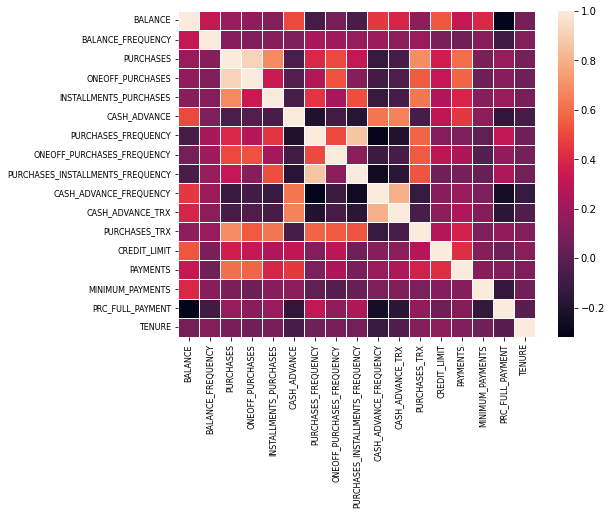

In [13]:
# plot a heatmap for the feature correlation in the original dataset

plot_heatmap(corrs, df.columns)

In [14]:
# select the highly correlated features from the `correlation` dataframe

correlations[(correlations.value.abs() > 0.6) & (correlations.feature1 != correlations.feature2)]

,feature1,feature2,value
34,PURCHASES,ONEOFF_PURCHASES,0.916845
35,PURCHASES,INSTALLMENTS_PURCHASES,0.679896
42,PURCHASES,PURCHASES_TRX,0.689561
44,PURCHASES,PAYMENTS,0.603264
69,INSTALLMENTS_PURCHASES,PURCHASES_TRX,0.628108
79,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,0.628522
80,CASH_ADVANCE,CASH_ADVANCE_TRX,0.656498
89,PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,0.862934
118,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,0.799561


The correlation tells the relationship between two variables. Thus, we may say
that **PURCHASES** and **ONEOFF_PURCHASES**, which makes sense since a customer,
who tends to have larger purchases, would tend to have larger oneoff purchases
as well. The figure below clearly somehow such relationship between **PURCHASES**
and **ONEOFF_PURCHASES**

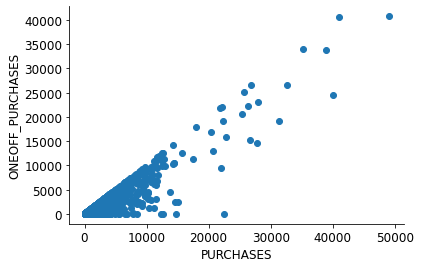

In [15]:
plot_scatter_features(df, 'PURCHASES', "ONEOFF_PURCHASES")

However, the correlation does not always tell the true relationship. i.e. **PURCHASES_FREQUENCY**
and **PURCHASES_INSTALLMENTS_FREQUENCY** does not have the same trend, thus
it may be still usefull to keep both features in the cluster analysis

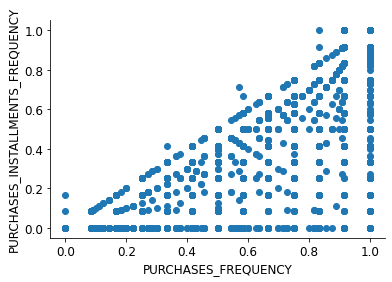

In [16]:
plot_scatter_features(df, 'PURCHASES_FREQUENCY', "PURCHASES_INSTALLMENTS_FREQUENCY")

Lastly, the skewness of the feature is important before proceding to the cluster
analysis. Thus, we use the variable *skewness* to determine hihgly skewed features

In [17]:
skewness

BALANCE                              2.393386
BALANCE_FREQUENCY                   -2.023266
PURCHASES                            8.144269
ONEOFF_PURCHASES                    10.045083
INSTALLMENTS_PURCHASES               7.299120
CASH_ADVANCE                         5.166609
PURCHASES_FREQUENCY                  0.060164
ONEOFF_PURCHASES_FREQUENCY           1.535613
PURCHASES_INSTALLMENTS_FREQUENCY     0.509201
CASH_ADVANCE_FREQUENCY               1.828686
CASH_ADVANCE_TRX                     5.721298
PURCHASES_TRX                        4.630655
CREDIT_LIMIT                         1.522636
PAYMENTS                             5.907620
MINIMUM_PAYMENTS                    13.852446
PRC_FULL_PAYMENT                     1.942820
TENURE                              -2.943017
dtype: float64

We see that features such as **ONEOFF_PURCHASES** and **MINIMUM_PAYMENTS** are highly
skewed and may not be informative in cluster analysis. The corresponding histograms
validate the skewness of each feature. Therefore, we select those features that have
a skew metric less that 5 in further analysis (PRC_FULL_PAYMENTS and TENURE are
excluded from this skew analysis).

In [18]:
skewness.abs() < 5

BALANCE                              True
BALANCE_FREQUENCY                    True
PURCHASES                           False
ONEOFF_PURCHASES                    False
INSTALLMENTS_PURCHASES              False
CASH_ADVANCE                        False
PURCHASES_FREQUENCY                  True
ONEOFF_PURCHASES_FREQUENCY           True
PURCHASES_INSTALLMENTS_FREQUENCY     True
CASH_ADVANCE_FREQUENCY               True
CASH_ADVANCE_TRX                    False
PURCHASES_TRX                        True
CREDIT_LIMIT                         True
PAYMENTS                            False
MINIMUM_PAYMENTS                    False
PRC_FULL_PAYMENT                     True
TENURE                               True
dtype: bool

# C. K-means clustering: Find optimal K using features 2-16

In [19]:
def calculate_optimal_k(inertias, threshold=0.1):
    """
    Returns an optimal K for given set of inertias
    inertias: inertia metric for the clustering method
    threshold: the threshold to calculate the optimal K
    i.e. computes te first K that has an almost linear
    slope in the k vs inertia plot
    """
    for i, inertia in enumerate(inertias):
        if i == len(inertias) - 2:
            print(f'No optimal K has been found using {threshold}')
            break

        slope = inertias[i+1] - inertia
        next_slope = inertias[i+2] - inertias[i+1]
        variation = next_slope / slope

        print(i+1, variation)
        if variation < 1 + threshold and variation> 1 - threshold:
            return i+1

        # if variation < threshold:
        #     return i+1

In [20]:
def plot_elbow_method(inertias, optimal_number):
    """
    Plots the k vs inertias, and a vertical line for the optimal K
    inertias: inertia metric for the clustering method
    optimal_nuber: the 'optimal' number of clusters
    """
    plt.figure(figsize=(7, 5))
    plt.plot(range(1, len(inertias)+1), inertias, 'bo--', label='inertia')
    plt.axvline(x=optimal_number, linestyle='dashed', c='red', label='optimal K')
    plt.title('Elbow method', fontsize=17)
    plt.xlabel('Number of clusters K', fontsize=14)
    plt.ylabel('Inertia', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim([0, len(inertias)+1])
    plt.grid()
    plt.legend()
    plt.show()

In [21]:
def print_costumers(labels):
    """
    Prints the number of customers in each cluster
    labels: the labels in a single array
    """
    values, counts = np.unique(labels, return_counts=True)
    heading = '{:9s} {}'.format('cluster', '#users')
    print(heading)
    print('-' * len(heading))
    for value, count in zip(values, counts):
        print('{:7} {:8.0f}'.format(value, count))

In [22]:
def print_centroids(centers, columns):
    """
    Print the centroids for each cluster in a nice manner
    centers: the center of each clusters
    columns: the column names for features
    """
    cluster_id = pd.DataFrame(data=np.arange(len(centers)), columns=['cluster_id'])
    centroids = pd.DataFrame(data=centers, columns=columns)
    return pd.concat((cluster_id, centroids), axis=1)

In [23]:
def print_distances(data, labels, centers):
    """
    Print the average summantion of distances of each instances to the
    corresponding cluster
    data: the dataset (instances by features)
    labels: the labels for each instances
    centers: the center of each cluster
    """
    values = []
    for i, center in enumerate(centers):
        instances = data[labels == i]
        n_instances, n_features = instances.shape
        n_center = np.repeat(center.reshape(1, n_features), n_instances, axis=0)
        distances2 = np.power(instances - n_center, 2).sum(axis=1)
        distances = np.power(distances2, 0.5)
        values.append([i, distances.mean()])
    return pd.DataFrame(data=values, columns=['cluster_id', 'mean_distance'])

In [24]:
def draw_instances_cluster(data, labels, n_clusters, title=None, type_redu='PCA', elevation=45, azimuth=45):
    fig = plt.figure(figsize=(9, 9))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(elev=elevation, azim=azimuth, vertical_axis='z')

    for i in range(n_clusters):
        mask = labels == i
        ax.scatter3D(data[mask, 0], data[mask, 1], data[mask, 2], label="cluster {}".format(i))

    ax.set_title(title, fontsize=17)
    ax.set_xlabel(f'{type_redu}1', fontsize=12)
    ax.set_ylabel(f'{type_redu}2', fontsize=12)
    ax.set_zlabel(f'{type_redu}3', fontsize=12)
    plt.legend(fontsize=9)
    plt.show()

In [25]:
# We normalize the dataset using a standard scalar (mean=0, std=1) and use the
# features 2-16

sc = StandardScaler()
X = sc.fit_transform(df[df.columns[0:15]])

In [26]:
# PCA is used for visualization purposes

pca = PCA(n_components=3, svd_solver='randomized', random_state=123)
pca.fit(X)
pca_x = pca.transform(X)

In [27]:
# iteratively compute run K-means for several values of K, and save the inertia
# metric for each K. random_state is set to 123 for reproductivility from now on

inertias = []

for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=123, init='k-means++')
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

In [28]:
# we find the optimal K based in the inertias, even though the function
# `calculate_optimal_k` helps to determine a value, we also need to look
# at the K vs inertia plot

k_full_optimal = calculate_optimal_k(inertias, threshold=0.05)
k_full_optimal

1 0.6836757778655286
2 0.783637654970899
3 0.5935073738181699
4 0.8380997551953504
5 0.8326961654300766
6 0.8899723304153125
7 0.7390414278019519
8 0.7206912979396419
9 0.9514871732153446


9

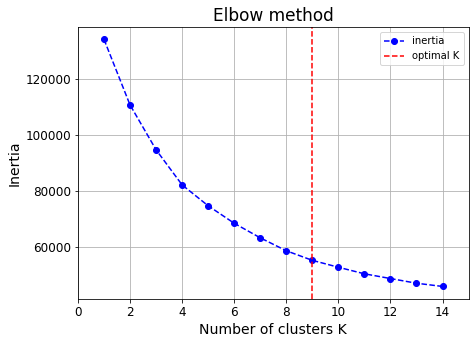

In [29]:
plot_elbow_method(inertias, k_full_optimal)

The optimal **K*** is 9 (vertical red line), but it is hard to tell whether 9 is
the best number of clusters since the curve becomes approximatly linear after 7
clusters. However, here we set the optimal $K^*=9$ when using 2-16 features

In [30]:
# we run a K-means using the optimal K, and save the labels into a column in the
# dataframe as `label_full_features`

kmeans = KMeans(n_clusters=k_full_optimal, random_state=123, init='k-means++')
kmeans.fit(X)
df['label_full_features'] = kmeans.labels_

In [31]:
# the number of users on each cluster when using 2-16 features

print_costumers(kmeans.labels_)

cluster   #users
----------------
      0     1304
      1     2592
      2       23
      3      385
      4     2206
      5     1211
      6      117
      7     1075
      8       37


In [32]:
# centroid of each cluster

print_centroids(kmeans.cluster_centers_, df.columns[0:15])

,cluster_id,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS
0,0,-0.694554,-2.128966,-0.314461,-0.234499,-0.312624,-0.305991,-0.571957,-0.437749,-0.462564,-0.484464,-0.360549,-0.427785,-0.207830,-0.219280,-0.284137
1,1,-0.090531,0.372255,-0.367260,-0.248348,-0.412013,-0.134726,-0.894242,-0.407830,-0.790936,0.061429,-0.083781,-0.497643,-0.401720,-0.285547,-0.082494
2,2,1.865907,0.332878,12.596844,13.111182,5.696389,-0.004178,1.033322,2.170634,0.866221,-0.476183,-0.214854,4.566558,3.174213,8.991136,1.072085
3,3,0.958373,0.462940,2.420363,1.787757,2.438485,-0.189874,1.162018,1.574035,1.263452,-0.301214,-0.190610,2.974997,1.268811,1.342799,0.350501
4,4,-0.390202,0.312592,-0.065854,-0.255321,0.313311,-0.364224,0.964854,-0.410356,1.157368,-0.463608,-0.359332,0.131366,-0.319043,-0.248025,-0.097842
5,5,-0.119164,0.389389,0.483361,0.616726,0.009741,-0.323740,0.934160,1.826775,0.131810,-0.397573,-0.324928,0.551852,0.401214,0.101097,-0.144989
6,6,1.952861,0.272229,0.136855,0.118203,0.106051,5.073267,-0.236796,0.018648,-0.165875,2.459708,3.998912,0.107954,1.569467,3.900181,0.603955
7,7,1.355858,0.386705,-0.290847,-0.210236,-0.301513,1.324503,-0.594527,-0.291157,-0.518144,1.697580,1.382551,-0.353365,0.731427,0.255634,0.298202
8,8,1.299171,0.455853,-0.051371,-0.271244,0.376157,-0.010364,-0.011158,-0.532469,0.230336,-0.241518,-0.060225,0.197608,0.006400,-0.092120,11.482043


In [33]:
# scatter average distance to each cluster

print_distances(X, kmeans.labels_, kmeans.cluster_centers_)

,cluster_id,mean_distance
0,0,1.692106
1,1,1.476110
2,2,9.450136
3,3,4.438228
4,4,1.639290
5,5,2.324137
6,6,5.879152
7,7,2.890812
8,8,5.574530


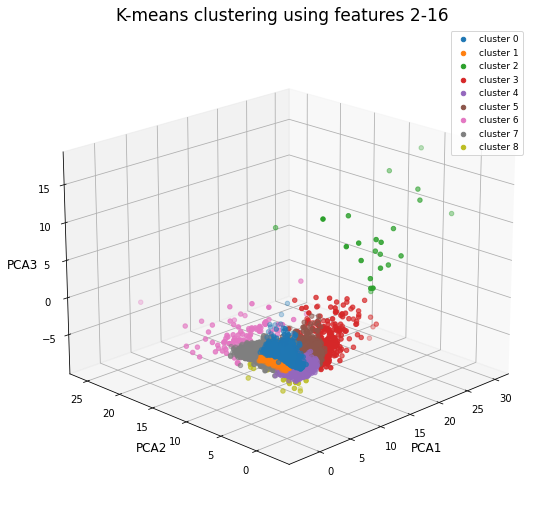

In [34]:
# a visualization for the K-means clustering using 2-16 features

draw_instances_cluster(pca_x, kmeans.labels_, k_full_optimal,
                       title='K-means clustering using features 2-16',
                       type_redu='PCA',
                       elevation=20, azimuth=-135)

In [35]:
# we analyze the costumer segmentation with respect of features PRC_FULL_PAYMENT
# and TENURE, more specifically, the mean and standard deviation metrics.
# In addition, the BALANCE, PURCHASES and PAYMENTS provides a better insight
# on each cluster

df[['PRC_FULL_PAYMENT', 'TENURE', 'BALANCE', 'PURCHASES', 'PAYMENTS', 'CREDIT_LIMIT', 'label_full_features']]\
    .groupby(by=['label_full_features'])\
    .aggregate({'mean', 'std'})

PRC_FULL_PAYMENT               TENURE            \
                                mean       std       mean       std   
label_full_features                                                   
0                           0.229026  0.348506  11.368865  1.495343   
1                           0.024508  0.072818  11.513503  1.328593   
2                           0.515316  0.414354  11.913043  0.417029   
3                           0.243378  0.372860  11.963636  0.366184   
4                           0.249603  0.341245  11.482774  1.415951   
5                           0.258126  0.362281  11.724195  1.020404   
6                           0.115172  0.176053  11.538462  1.310031   
7                           0.029145  0.093164  11.360000  1.497260   
8                           0.000000  0.000000  11.918919  0.276725   

                         BALANCE                  PURCHASES               \
                            mean          std          mean          std   
label_full_features                                                        
0                     118.819335   252.423043    331.354709   477.534002   
1                    1376.041781  1067.499673    218.547407   397.178476   
2                    5448.201718  4409.774373  27916.555652  8172.003282   
3                    3559.247264  3254.812993   6174.348052  2975.391943   
4                     751.791307  1038.998118    860.815014   733.209540   
5                    1316.443705  1523.995621   2037.055690  1318.164895   
6                    5629.191180  3175.925564   1295.598034  2170.476881   
7                    4386.578631  2676.773284    381.806614   655.491658   
8                    4268.589649  2319.685427    893.449189  1489.079417   

                         PAYMENTS               CREDIT_LIMIT               
                             mean          std          mean          std  
label_full_features                                                        
0                     1098.350067  2341.589364   3738.105402  3178.449658  
1                      906.513048  1015.247603   3032.645319  2301.705911  
2                    27761.600386  9280.015011  16043.478261  5692.724710  
3                     5620.415265  3626.107405   9110.779221  4407.760606  
4                     1013.708455  1002.661386   3332.179684  2704.973909  
5                     2026.738857  1611.239900   5952.088432  3729.340075  
6                    13023.785494  7874.143309  10204.700855  3813.496805  
7                     2473.178375  2178.083631   7155.539112  3603.451287  
8                     1466.465369  2055.493352   4517.567568  2818.840784

`Discussion`: **PRC_FULL_PAYMENT** and **TENURE** are metrics that indicates a
percentage of full payments and age of the credit service. To help distinguish
clusters, we also use the BALANCE, PURCHASES, PAYMENTS and CREDIT_LIMIT.

We summarize the analysis for each cluster in terms of means. The goal in mind
is to aid in further actions (i.e. offers, credit limit increase, points, etc),
thus we decribe each cluster using a few metrics, and finally define whether
a cluster is very risky, risky, good, pretty good. For example in the table
below, *cluster 0* has PRC_FULL_PAYMENT of 0.23 meaning the cluster pays full
balance a fair amount of times, a TENURE of 11.37 meaning the cluster is
relativetly young among all costumers. In addition, *cluster 0* makes more
payments than balance meaning the cluster keeps a small remaining balalnce in
average, and the cluster does not purchases much in average. Therefore, *cluster
0* is **good** to give offers (i.e. cash back), thus they can spend more.

<table>
  <tr>
    <th>cluster_id</th>
    <th>PRC_FULL_PAYMENT</th>
    <th>TENURE</th>
    <th>Description</th>
    <th>Conclusion</th>
  </tr>

  <tr>
    <td>0</td>
    <td>fair</td>
    <td>young</td>
    <td>more payments than balance, and a small purchases</td>
    <td>good</td>
  </tr>
  <tr>
    <td>1</td>
    <td>tiny</td>
    <td>young</td>
    <td>less payments than balance, and small purchases</td>
    <td>risky</td>
  </tr>
  <tr>
    <td>2</td>
    <td>good</td>
    <td>good</td>
    <td>more payments than balance, but a large purchases, tiny group</td>
    <td>risky</td>
  </tr>
  <tr>
    <td>3</td>
    <td>fair</td>
    <td>good</td>
    <td>more payments than balance, a large purchases</td>
    <td>good</td>
  </tr>
  <tr>
    <td>4</td>
    <td>fair</td>
    <td>fair</td>
    <td>more payments than balance, and a small purchases</td>
    <td>pretty good</td>
  </tr>
  <tr>
    <td>5</td>
    <td>fair</td>
    <td>fair</td>
    <td>more payments and balance, a small balance</td>
    <td>pretty good</td>
  </tr>
  <tr>
    <td>6</td>
    <td>tiny</td>
    <td>fair</td>
    <td>more payments than balance, a fair purchases</td>
    <td>highly risky</td>
  </tr>
  <tr>
    <td>7</td>
    <td>bad</td>
    <td>young</td>
    <td>less payments than balance, a small purchases</td>
    <td>highly risky</td>
  </tr>
  <tr>
    <td>8</td>
    <td>bad</td>
    <td>good</td>
    <td>less payments than balance, a fair purchases, tiny group</td>
    <td>risky</td>
  </tr>
</table>

We distinguish the segmentation using PRC_FULL_PAYMENT and TENURE, also BALANCE,
PURCHASES, PAYMENTS and CREDIT_LIMIT into highly risky, risky, good and pretty
good groups for business inteligence. However, the segmentation has 2 tini-tiny
groups that suggest a smaller number of clusters might be used. In the current
set of features, costumers in cluster 2 may be include into cluster 4 (cluster
2 is just below 4 in Figure above) when reducing the # clustes, thus mislabeling
risky costumer as pretty good. Therefore, a subset of features is a clever idea
to segmet the costumers.

# D. K-means clustering: Using only non-correlated and less skewed features

In [36]:
# the selected features are:

select_features = ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY',
                   'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
                   'CASH_ADVANCE_FREQUENCY', 'CREDIT_LIMIT']

In [37]:
# We normalize the dataset using a standard scalar (mean=0, std=1) and use the
# selected features

sc = StandardScaler()
X = sc.fit_transform(df[select_features])

In [38]:
# PCA is used for visualization purposes

pca = PCA(n_components=3, svd_solver='randomized', random_state=123)
pca.fit(X)
pca_x = pca.transform(X)

In [39]:
# iteratively compute run K-means for several values of K, and save the inertia
# metric for each K

inertias = []

for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=123, init='k-means++')
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

In [40]:
# we find the optimal K based in the inertias

k_selected_optimal = calculate_optimal_k(inertias, threshold=0.05)
k_selected_optimal

1 0.5106808884594216
2 0.7621363445776084
3 0.9127372088511734
4 0.427275337814928
5 0.6237585041983936
6 0.7232697854260741
7 1.0433162241815575


7

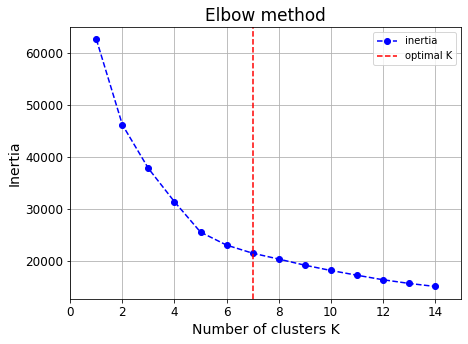

In [41]:
plot_elbow_method(inertias, k_selected_optimal)

The optimal **K*** is 7 (vertical red line), which is the best number of clusters
since the curve becomes approximatly linear after 7 clusters

In [42]:
# we run a K-means using the optimal K, and save the labels into a column in the
# dataframe as `label_selected_features`

kmeans = KMeans(n_clusters=k_selected_optimal, random_state=123, init='k-means++')
kmeans.fit(X)
df['label_selected_features'] = kmeans.labels_

In [43]:
# the number of users on each cluster when using selected features

print_costumers(kmeans.labels_)

cluster   #users
----------------
      0     2297
      1      494
      2     1289
      3      860
      4     2233
      5      581
      6     1196


In [44]:
# centroid of each cluster

print_centroids(kmeans.cluster_centers_, select_features)

,cluster_id,BALANCE,BALANCE_FREQUENCY,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CREDIT_LIMIT
0,0,-0.136670,0.355745,-0.833518,-0.377940,-0.751931,-0.192963,-0.377996
1,1,1.888157,0.458611,1.035699,0.964075,1.038263,0.431558,1.878792
2,2,-0.686613,-2.164384,-0.586803,-0.446668,-0.469703,-0.462966,-0.196087
3,3,0.150275,0.338084,-0.859068,-0.403182,-0.742357,1.816436,-0.273863
4,4,-0.394597,0.316467,0.993384,-0.378175,1.190176,-0.453685,-0.345906
5,5,2.234024,0.464839,-0.885074,-0.431588,-0.764306,1.356100,1.359897
6,6,-0.236047,0.400195,1.000026,2.016748,0.205289,-0.428032,0.342560


In [45]:
# scatter average distance to each cluster

print_distances(X, kmeans.labels_, kmeans.cluster_centers_)

,cluster_id,mean_distance
0,0,1.125581
1,1,2.431783
2,2,1.441818
3,3,1.382057
4,4,1.185847
5,5,1.780535
6,6,1.680187


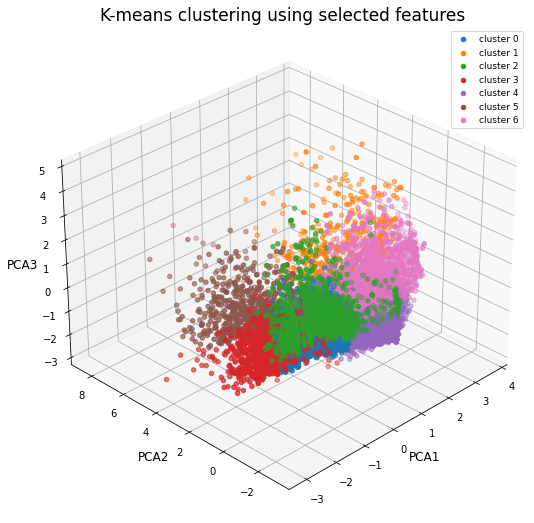

In [46]:
# a visualization for the K-means clustering using selected features

draw_instances_cluster(pca_x, kmeans.labels_, k_selected_optimal,
                       title='K-means clustering using selected features',
                       type_redu='PCA', elevation=30, azimuth=-135)

In [47]:
# we repeat the analysis using the mean and standard deviation of the 
# selected features

df[['PRC_FULL_PAYMENT', 'TENURE', 'BALANCE', 'PURCHASES', 'PAYMENTS', 'CREDIT_LIMIT', 'label_selected_features']]\
    .groupby(by=['label_selected_features'])\
    .aggregate({'mean', 'std'})

PRC_FULL_PAYMENT               TENURE            \
                                    mean       std       mean       std   
label_selected_features                                                   
0                               0.032488  0.099765  11.589029  1.198148   
1                               0.069383  0.210234  11.836032  0.797713   
2                               0.228499  0.349341  11.374709  1.485441   
3                               0.042200  0.107784  11.051163  1.830332   
4                               0.253708  0.343587  11.485446  1.409736   
5                               0.009722  0.037513  11.628227  1.130835   
6                               0.304215  0.380362  11.742475  0.992306   

                             BALANCE                 PURCHASES               \
                                mean          std         mean          std   
label_selected_features                                                       
0                        1280.007045   975.523606   295.192669   572.559635   
1                        5506.533917  2987.270392  4206.116700  5703.355693   
2                         135.348269   298.333723   357.383351   721.357177   
3                        1877.259852  1114.694286   228.729628   533.262019   
4                         743.153539   945.318632   980.538688  1014.487174   
5                        6213.859153  2125.353355   377.638468  1348.622769   
6                        1072.762841  1104.926683  2639.196145  2758.958231   

                            PAYMENTS               CREDIT_LIMIT               
                                mean          std          mean          std  
label_selected_features                                                       
0                         970.312237  1315.227462   3118.966768  2316.279381  
1                        5201.394214  6355.623934  11322.064777  4210.227211  
2                        1281.900749  3194.716793   3780.829670  3228.540519  
3                        1833.126594  2373.655544   3497.848837  2117.890015  
4                        1144.946205  1343.734009   3235.723333  2391.403819  
5                        3310.402571  4224.387347   9439.508684  2957.504052  
6                        2512.101854  2629.046810   5748.409091  3398.035823

`Discussion`: We summarize the analysis for each cluster as follow:

<table>
  <tr>
    <th>cluster_id</th>
    <th>PRC_FULL_PAYMENT</th>
    <th>TENURE</th>
    <th>Description</th>
    <th>Conclusion</th>
  </tr>

  <tr>
    <td>0</td>
    <td>tiny</td>
    <td>fair</td>
    <td>roughly same payments and balance, and a small purchases</td>
    <td>good</td>
  </tr>
  <tr>
    <td>1</td>
    <td>tiny</td>
    <td>good</td>
    <td>roughly same payments and balance, but a fair purchases</td>
    <td>good</td>
  </tr>
  <tr>
    <td>2</td>
    <td>fair</td>
    <td>young</td>
    <td>more payments than balance, and a fair purchases</td>
    <td>pretty good</td>
  </tr>
  <tr>
    <td>3</td>
    <td>tiny</td>
    <td>young</td>
    <td>roughly same payments and balance, a small purchases</td>
    <td>risky</td>
  </tr>
  <tr>
    <td>4</td>
    <td>fair</td>
    <td>fair</td>
    <td>more payments than balance, and fair purchases</td>
    <td>pretty good</td>
  </tr>
  <tr>
    <td>5</td>
    <td>tiny</td>
    <td>fair</td>
    <td>less payments than balance, but a small purchases</td>
    <td>highly risky</td>
  </tr>
  <tr>
    <td>6</td>
    <td>fair</td>
    <td>good</td>
    <td>more payments than balance, a fair purchases</td>
    <td>good</td>
  </tr>
</table>

The segmenation using selected features shows a evenly distributed clustering,
which may be preferable for business strategies. Also, cluster 2, and 4 are pretty
good target since these have consistency between balance and payments, being
relatively young tenure. Meanwhile, cluster 5 has very low rate of full payment
and the payment is less than the balance, thus become a hilgy risky group.

## Clustering using UMAP embedding

In [48]:
# We normalize the dataset using a standard scalar (mean=0, std=1) and use the
# 2-16 features

sc = StandardScaler()
X = sc.fit_transform(df[df.columns[0:15]])

In [49]:
# UMAP dimensionality reduction is performs for both visualization and 
# clustering. We set UMAP to reduce from 15 features to 4

umap = UMAP(n_components=4, n_neighbors=10, min_dist=0.05, random_state=123, n_jobs=1)
umap_x = umap.fit_transform(X)

In [50]:
# iteratively compute run K-means for several values of K, and save the inertia
# metric for each K. The input for clustering is the UMAP embedding

inertias = []

for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=123, init='k-means++')
    kmeans.fit(umap_x)
    inertias.append(kmeans.inertia_)

In [51]:
# we find the optimal K based in the inertias

k_umap_optimal = calculate_optimal_k(inertias, threshold=0.06)
k_umap_optimal

1 0.3405141064663824
2 0.39592481568135396
3 0.8495398745084712
4 0.8739279932927314
5 0.4650887174965595
6 0.9067720003514784
7 0.943594147740659


7

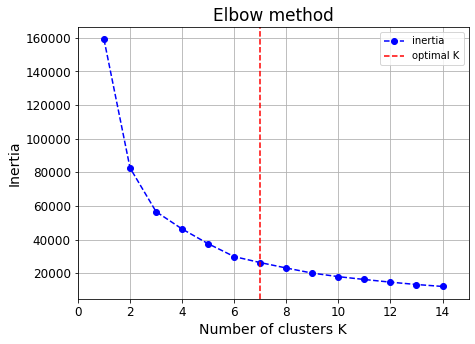

In [52]:
plot_elbow_method(inertias, k_umap_optimal)

When using the UMAP embedding, the optimal **K*** is 7 (vertical red line), which
is the best number of clusters since the curve becomes approximatly linear after
7 clusters. However, we choose the set the optimal **K*** to 8 to reduce the
inertia a bit more.

In [53]:
k_umap_optimal = 8

In [54]:
# we run a K-means using the optimal K, and save the labels into a column in the
# dataframe as `label_selected_features`

kmeans = KMeans(n_clusters=k_umap_optimal, random_state=123, init='k-means++')
kmeans.fit(umap_x)
df['umap_full_features'] = kmeans.labels_

In [55]:
# the number of users on each cluster when using the UMAP embedding for clustering

print_costumers(kmeans.labels_)

cluster   #users
----------------
      0     1275
      1     1531
      2      699
      3     1346
      4     1488
      5     1325
      6     1145
      7      141


In [56]:
# centroid of each cluster

print_centroids(kmeans.cluster_centers_, ['UMAP1', 'UMAP2', 'UMAP3', 'UMAP4'])

,cluster_id,UMAP1,UMAP2,UMAP3,UMAP4
0,0,6.354665,3.476682,4.482128,5.880241
1,1,2.513573,10.156652,2.978813,3.733033
2,2,5.922396,9.472513,3.460044,4.252408
3,3,0.333256,8.871145,4.624470,4.501596
4,4,7.508004,8.838004,1.680403,6.247199
5,5,9.246245,7.807389,4.244059,4.685400
6,6,5.532634,7.484864,4.729566,6.583990
7,7,3.299929,10.287754,8.317198,5.995454


In [57]:
# scatter average distance to each cluster

print_distances(umap_x, kmeans.labels_, kmeans.cluster_centers_)

,cluster_id,mean_distance
0,0,1.767561
1,1,1.333368
2,2,1.196863
3,3,1.748347
4,4,1.338652
5,5,1.642027
6,6,1.497734
7,7,0.501433


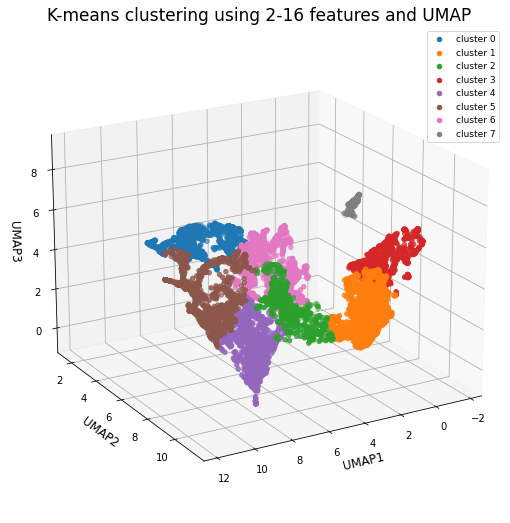

In [58]:
# a visualization for the K-means clustering using UMAP embedding

draw_instances_cluster(umap_x, kmeans.labels_, k_umap_optimal,
                       title='K-means clustering using 2-16 features and UMAP',
                       type_redu='UMAP',
                       elevation=20, azimuth=60)

In [59]:
# Similarly, we use the same analysis using the mean and standard deviation of the 
# some features to understand the segmentation

df[['PRC_FULL_PAYMENT', 'TENURE', 'BALANCE', 'PURCHASES', 'PAYMENTS', 'CREDIT_LIMIT', 'umap_full_features']]\
    .groupby(by=['umap_full_features'])\
    .aggregate({'mean', 'std'})

PRC_FULL_PAYMENT               TENURE            \
                               mean       std       mean       std   
umap_full_features                                                   
0                          0.260113  0.354572  11.491765  1.363537   
1                          0.035976  0.109603  11.406270  1.452809   
2                          0.045106  0.122447  11.301860  1.618884   
3                          0.048698  0.146215  11.231798  1.640038   
4                          0.275626  0.372362  11.863575  0.704155   
5                          0.310456  0.366020  11.499623  1.389769   
6                          0.059322  0.181159  11.695197  1.038853   
7                          0.017988  0.063120  11.815603  0.682462   

                        BALANCE                 PURCHASES               \
                           mean          std         mean          std   
umap_full_features                                                       
0                     74.376882   169.589762   419.568424   455.860477   
1                   3760.319204  2678.282934   229.728060   506.876854   
2                   2499.936103  2124.657827  1072.663076  1125.124954   
3                   1014.317549   768.079103    44.323239   146.047349   
4                   1861.490820  2353.618283  3630.889449  4096.268299   
5                    488.608644   669.507794   786.859034   614.712342   
6                   1117.957513  1044.639134   678.762725   738.764748   
7                   2411.897732  1912.756210   425.774823   899.455074   

                       PAYMENTS              CREDIT_LIMIT               
                           mean          std         mean          std  
umap_full_features                                                      
0                    758.732536  1070.158771  3859.080650  3098.320814  
1                   2898.187427  4154.188145  6409.963779  3828.502387  
2                   2231.710044  2998.380377  4488.483548  3422.493183  
3                    866.862786  1022.855748  2319.588905  1639.318537  
4                   3370.859867  4234.842187  6924.026760  4193.097175  
5                    839.341703   736.154193  3133.773585  2789.882608  
6                    951.345863  1139.140299  3821.726876  2994.165830  
7                   1156.791905  1515.751365  2830.851064  2214.559450

`Discussion`: We analyze the segmentation produced by clustering using the UMAP
embedding. Below, a table that summarize the analysis:

<table>
  <tr>
    <th>cluster_id</th>
    <th>PRC_FULL_PAYMENT</th>
    <th>TENURE</th>
    <th>Description</th>
    <th>Conclusion</th>
  </tr>

  <tr>
    <td>0</td>
    <td>fair</td>
    <td>fair</td>
    <td>more payments than balance, and a small purchases</td>
    <td>pretty good</td>
  </tr>
  <tr>
    <td>1</td>
    <td>tiny</td>
    <td>fair</td>
    <td>less payments than balance, but a small purchases</td>
    <td>good</td>
  </tr>
  <tr>
    <td>2</td>
    <td>tiny</td>
    <td>young</td>
    <td>roughly same payments and balance, and a fair purchases</td>
    <td>good</td>
  </tr>
  <tr>
    <td>3</td>
    <td>tiny</td>
    <td>young</td>
    <td>less payments than balance, a small purchases</td>
    <td>risky</td>
  </tr>
  <tr>
    <td>4</td>
    <td>fair</td>
    <td>good</td>
    <td>more payments and balance, and fair purchases</td>
    <td>pretty good</td>
  </tr>
  <tr>
    <td>5</td>
    <td>good</td>
    <td>fair</td>
    <td>more payments than balance, but a fair purchases</td>
    <td>pretty good</td>
  </tr>
  <tr>
    <td>6</td>
    <td>tiny</td>
    <td>good</td>
    <td>less payments than balance, and fair purchases</td>
    <td>good</td>
  </tr>
  <tr>
    <td>7</td>
    <td>tiny</td>
    <td>good</td>
    <td>less payments than balance, a tiny purchases</td>
    <td>highly risky</td>
  </tr>
</table>

The segmentation devides the costumers into 8 distinguishable clusters.
Clusters 0, 5 and 4 are labeled as pretty good and located to the left in
the figure above. Clusters 1, 2 and 6 are labeled as good and located in the
middle in the figure. Clusters 3 and 7 are labeled as risky and highly risky
repectivetly, and located to the right of the figure. Thus, UMAP not only provide
intra-cluster but also inter-cluster information, which means the relative
position among clusters also provides insights. i.e. Cluster on the right are
both risky groups.

The clustering using UMAP embeddin also provides even distributed cluster
that is preferable for furthers strategies.

# E. Gaussin mixture models: Using selected features and optimal K* from D

In [60]:
# We normalize the dataset using a standard scalar (mean=0, std=1) and use the
# 2-16 features

sc = StandardScaler()
X = sc.fit_transform(df[select_features])

In [61]:
# we use GMMs using the optimal K, and save the labels into a column in the
# dataframe as `label_gaussian_selected`

gm = GaussianMixture(n_components=k_selected_optimal, random_state=123)
gm.fit(X)
df['label_gmm_selected'] = gm.predict(X)

In [62]:
# the number of users on each cluster when using the UMAP embedding for clustering

print_costumers(gm.predict(X))

cluster   #users
----------------
      0     2560
      1      415
      2     3521
      3      135
      4      889
      5     1302
      6      128


In [63]:
# mean vector for each cluster, columns are the features used in the clustering

print_centroids(gm.means_, select_features)

,cluster_id,BALANCE,BALANCE_FREQUENCY,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CREDIT_LIMIT
0,0,-0.291300,0.518084,0.842429,0.473668,0.718372,-0.675349,0.017332
1,1,-0.630152,-0.737408,0.320638,0.150043,0.254853,-0.675349,0.434415
2,2,0.164533,-0.035703,-0.949407,-0.312249,-0.916995,0.448990,-0.106746
3,3,0.338008,-0.056046,0.651652,0.760087,0.365540,0.912266,0.854079
4,4,-0.739597,-1.547386,0.095553,-0.619636,0.291472,-0.675349,-0.443937
5,5,0.863287,0.518084,0.654785,0.275308,0.706379,0.688862,0.391498
6,6,-0.428849,-0.676919,0.218030,-0.359894,0.331589,0.207397,-0.494364


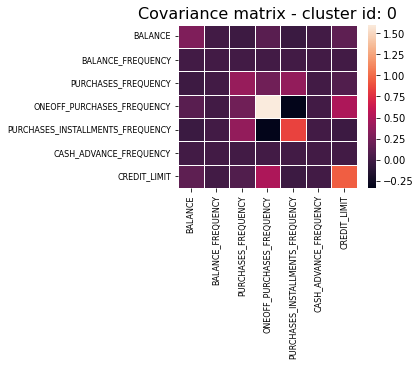

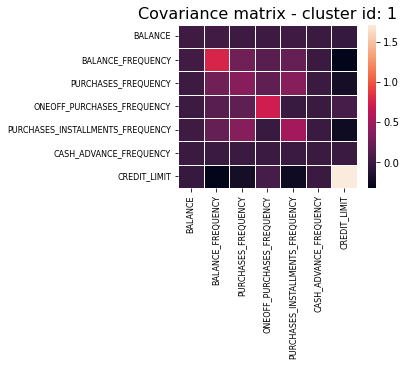

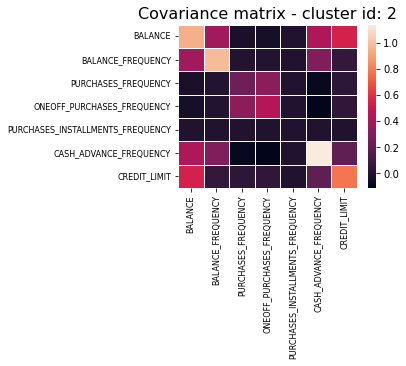

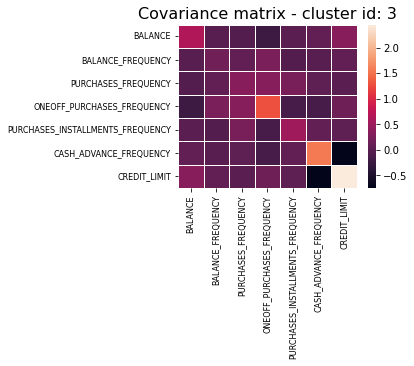

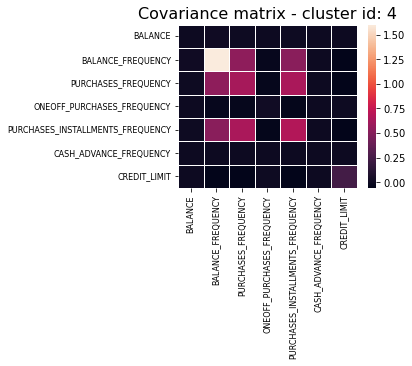

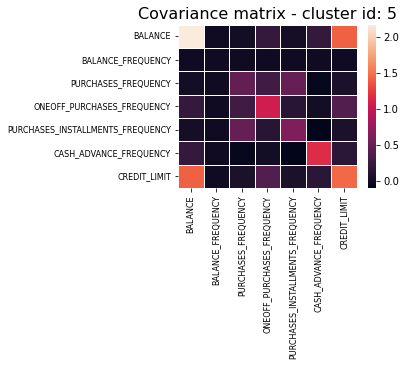

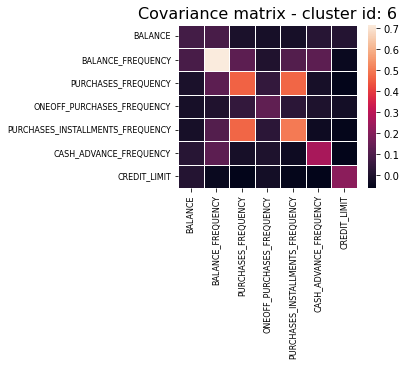

In [64]:
# the covariance matrix for each Gaussian

for i, matrix in enumerate(gm.covariances_):
    plt.figure(figsize=(4,3))
    sns.heatmap(matrix, linewidths=.5)
    plt.xticks(np.arange(7)+0.5, select_features, rotation=90, fontsize=8)
    plt.yticks(np.arange(7)+0.5, select_features, rotation=0,fontsize=8)
    plt.title(f"Covariance matrix - cluster id: {i}", fontsize=16)
    plt.show()

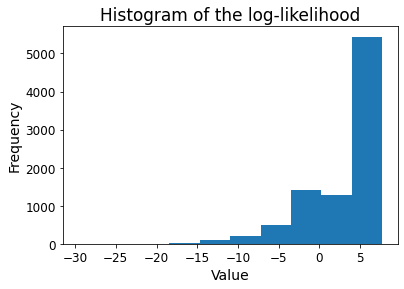

In [65]:
# histogram of log-likelihood of each data sample

plt.figure()
plt.hist(gm.score_samples(X))
plt.xlabel('Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Histogram of the log-likelihood", fontsize=17)
plt.show()

The log-likelihood is a measure of goodness, thus the larger the better. However,
several instances are below 0 which means these instances are not well-clustered.
The similarities among clusters are typically well defined, but the figure below
shows overlap between cluster, thus some miss-assigning into the wrong cluster

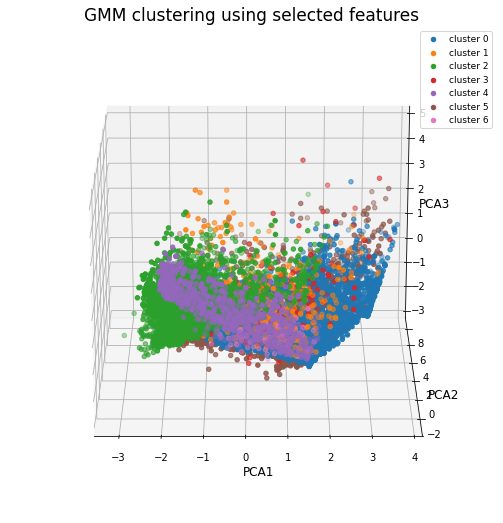

In [66]:
# a visualization for the GMM clustering using selected features

draw_instances_cluster(pca_x, gm.predict(X), k_selected_optimal,
                       title='GMM clustering using selected features',
                       type_redu='PCA', elevation=20, azimuth=-90)

In [67]:
# we sumarize the mterics using the mean and standard deviation

df[['PRC_FULL_PAYMENT', 'TENURE', 'BALANCE', 'PURCHASES', 'PAYMENTS', 'CREDIT_LIMIT', 'label_gmm_selected']]\
    .groupby(by=['label_gmm_selected'])\
    .aggregate({'mean', 'std'})

PRC_FULL_PAYMENT               TENURE            \
                               mean       std       mean       std   
label_gmm_selected                                                   
0                          0.250492  0.359820  11.764844  0.984927   
1                          0.333210  0.360509  11.421687  1.392878   
2                          0.059809  0.177261  11.346776  1.520278   
3                          0.129367  0.248058  10.659259  1.920677   
4                          0.326921  0.368362  11.479190  1.356443   
5                          0.048553  0.141424  11.707373  1.083561   
6                          0.111733  0.205874  10.804688  1.936222   

                        BALANCE                 PURCHASES               \
                           mean          std         mean          std   
label_gmm_selected                                                       
0                    937.570051  1106.876954  1691.006309  2654.157307   
1                    257.806999   302.957264  1355.764795  1443.930885   
2                   1909.836132  2030.895366   299.086828   978.014099   
3                   2274.688200  1656.392840  2704.686667  4170.783309   
4                     23.709937    24.017519   314.376412   320.384554   
5                   3347.012960  3051.604320  1767.747704  2975.895124   
6                    659.183867   587.648063   685.618438   677.663967   

                       PAYMENTS              CREDIT_LIMIT               
                           mean          std         mean          std  
label_gmm_selected                                                      
0                   1616.469329  2424.208098  4531.503906  3537.520747  
1                   1830.096694  2503.185851  6058.630887  4759.442769  
2                   1608.841250  2741.344575  4110.551496  3219.758906  
3                   4417.860533  5349.545772  7664.444444  5745.468255  
4                    497.917773   783.511462  2907.517867  1771.602213  
5                   2867.655721  4124.319844  5891.013825  4377.151375  
6                   1378.968761  1524.564045  2703.211806  1705.702757

`Discussion`: We analyze the segmentation produced by GMM clustering. Below, a
table that summarize the analysis:

<table>
  <tr>
    <th>cluster_id</th>
    <th>PRC_FULL_PAYMENT</th>
    <th>TENURE</th>
    <th>Description</th>
    <th>Conclusion</th>
  </tr>

  <tr>
    <td>0</td>
    <td>fair</td>
    <td>fair</td>
    <td>more payments than balances, and fair purchases</td>
    <td>good</td>
  </tr>
  <tr>
    <td>1</td>
    <td>fair</td>
    <td>fair</td>
    <td>more payments than balance, but small purchases</td>
    <td>pretty good</td>
  </tr>
  <tr>
    <td>2</td>
    <td>tiny</td>
    <td>young</td>
    <td>roughly same payments and balance, and a small purchases</td>
    <td>risky</td>
  </tr>
  <tr>
    <td>3</td>
    <td>tiny</td>
    <td>young</td>
    <td>more payments than balance, a fair purchases</td>
    <td>risky</td>
  </tr>
  <tr>
    <td>4</td>
    <td>good</td>
    <td>fair</td>
    <td>more payments than balance, and fair purchases</td>
    <td>pretty good</td>
  </tr>
  <tr>
    <td>5</td>
    <td>tiny</td>
    <td>good</td>
    <td>less payments than balance, a good purchases</td>
    <td>highly risky</td>
  </tr>
  <tr>
    <td>6</td>
    <td>tiny</td>
    <td>young</td>
    <td>more payment than balance, and fair purchases</td>
    <td>good</td>
  </tr>
</table>

The GMM segmentation shows cluster 5 highly risky group that has a *PCR_FULL_PAYMENTS*
even though these costumers are *TENURE*, which means they do not pay the balance
completly nor fequently.

On the other hand, clusters 1 and 4 tipically pay the full balance (*PCR_FULL_PAYMENTS*)
and are *TENURE* enough, besides these costumers keep their purchases small
with respect to the *CREDIT_LIMIT*.